This notebook describes the steps performed to create the product corresponding to the *Benthos specific species* defined by Olivier.

In [19]:
using DIVAnd
using PyPlot
using NCDatasets
using Missings
using Interpolations

if VERSION >= v"0.7"
    using Random
    using DelimitedFiles
    using Statistics
    using Printf
    using FileIO
else
    using Compat: @info, @warn, range, cat
end

In [42]:
# Module where the output grid and the modules are defined
include("../src/emodnet_bio_grid.jl");
include("../src/make_benthos_products.jl");
include("../src/make_fishs_products.jl");

In [46]:
datafile = joinpath(datadir, "Benthos-Specific/Benthos_Specific_cases.csv");
outputfile = joinpath(outputdirBenthos, replace(basename(datafile), ".csv" => ".nc"))

"../output/benthos/Benthos_Specific_cases.nc"

### Read data

In [22]:
@info "Reading data file $(datafile)"
obslon, obslat, g1, g2, g3 = read_benthos_specific(datafile);
@info extrema(obslat)
@info extrema(obslon) 
@info extrema(gridlonBenthos)
@info extrema(gridlatBenthos) 

┌ Info: Reading data file /home/ctroupin/tmp/Emodnet-Bio/Benthos-Specific/Benthos_Specific_cases.csv
└ @ Main In[22]:1
┌ Info: (41.3894, 72.579834)
└ @ Main In[22]:3
┌ Info: (-9.39937, 34.328014)
└ @ Main In[22]:4
┌ Info: (-10.0, 35.0)
└ @ Main In[22]:5
┌ Info: (36.0, 73.0)
└ @ Main In[22]:6


### Make plot

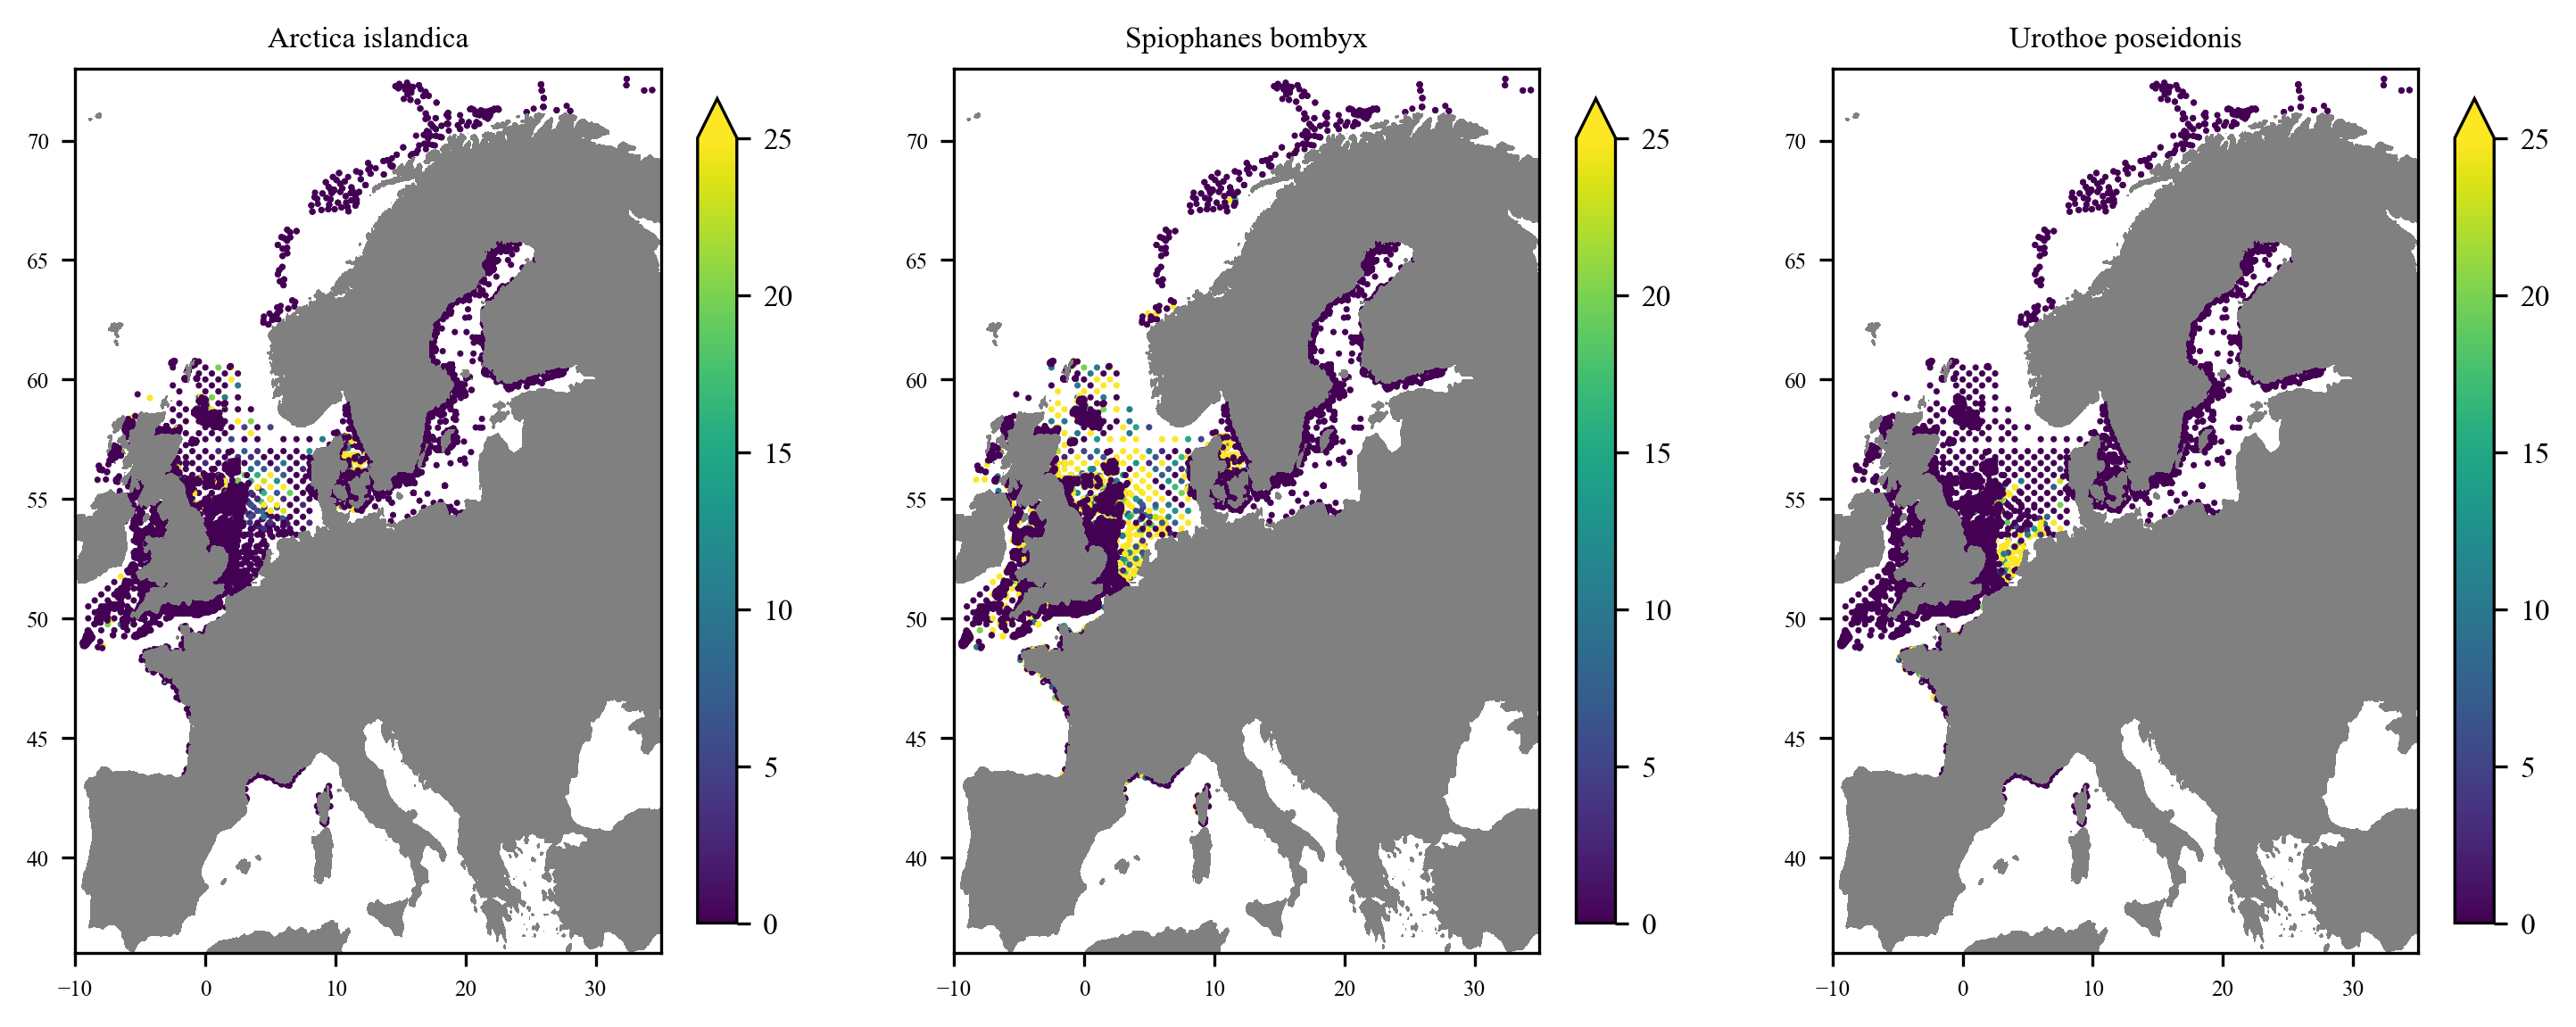

In [24]:
make_scatter_grid_specific(g1, g2, g3, vmin=0., vmax=25.)
PyPlot.savefig(joinpath(figdirBenthos, "Benthos_Specific_cases_data.png"), 
        dpi=300, bbox_inches="tight")

## Prepare the grid and the mask

In [25]:
# Grid stored in emodnet_bio_grid.jl
xi,yi = DIVAnd.ndgrid(gridlonBenthos, gridlatBenthos);

# Mask
topodir = "../data/"
topofile = joinpath(topodir, "gebco_30sec_8.nc");

if isfile(topofile)
    bx, by, b = DIVAnd.load_bath(topofile,true,gridlonBenthos, gridlatBenthos);
    xmask, ymask, mmask = DIVAnd.load_mask(topofile,true,gridlonBenthos, gridlatBenthos,[0]);
else
    @error "Bathymetry file doesn't exist"
end
mmask = mmask[:,:,1]
@info size(mmask)

# Metrics
pm = ones(size(xi)) / (xi[2,1]-xi[1,1]);
pn = ones(size(xi)) / (yi[1,2]-yi[1,1]);

┌ Info: (451, 371)
└ @ Main In[25]:15


## Parameter choice 
Chose via sensitivity analysis, as the optimisation tools provide too low values for L and noise-to-signal ratio.

In [26]:
# Correlation length
len = 2.;
# Observational error variance normalized by the background error variance
epsilon2 = 5.;

The weight is decreased for very close points.

In [27]:
rdiag=1.0./DIVAnd.weight_RtimesOne((obslon, obslat),(0.03,0.03))
@show maximum(rdiag),mean(rdiag);
epsilon2 = epsilon2*rdiag;

(maximum(rdiag), mean(rdiag)) = (439.41430043634097, 33.62322573600825)


## Perform analysis

In [28]:
@info "Interpolating"
fi1rel, fi2rel, fi3rel, totalfield = make_analysis(obslon, obslat, g1, g2, g3);
fi1abs, fi2abs, fi3abs = fi1rel .* totalfield, fi2rel .* totalfield, fi3rel .* totalfield;

┌ Info: Interpolating
└ @ Main In[28]:1


  1.402383 seconds (2.30 M allocations: 1.450 GiB, 39.29% gc time)
  1.364862 seconds (2.30 M allocations: 1.450 GiB, 39.55% gc time)
  1.324881 seconds (2.30 M allocations: 1.450 GiB, 37.71% gc time)


### Make plots

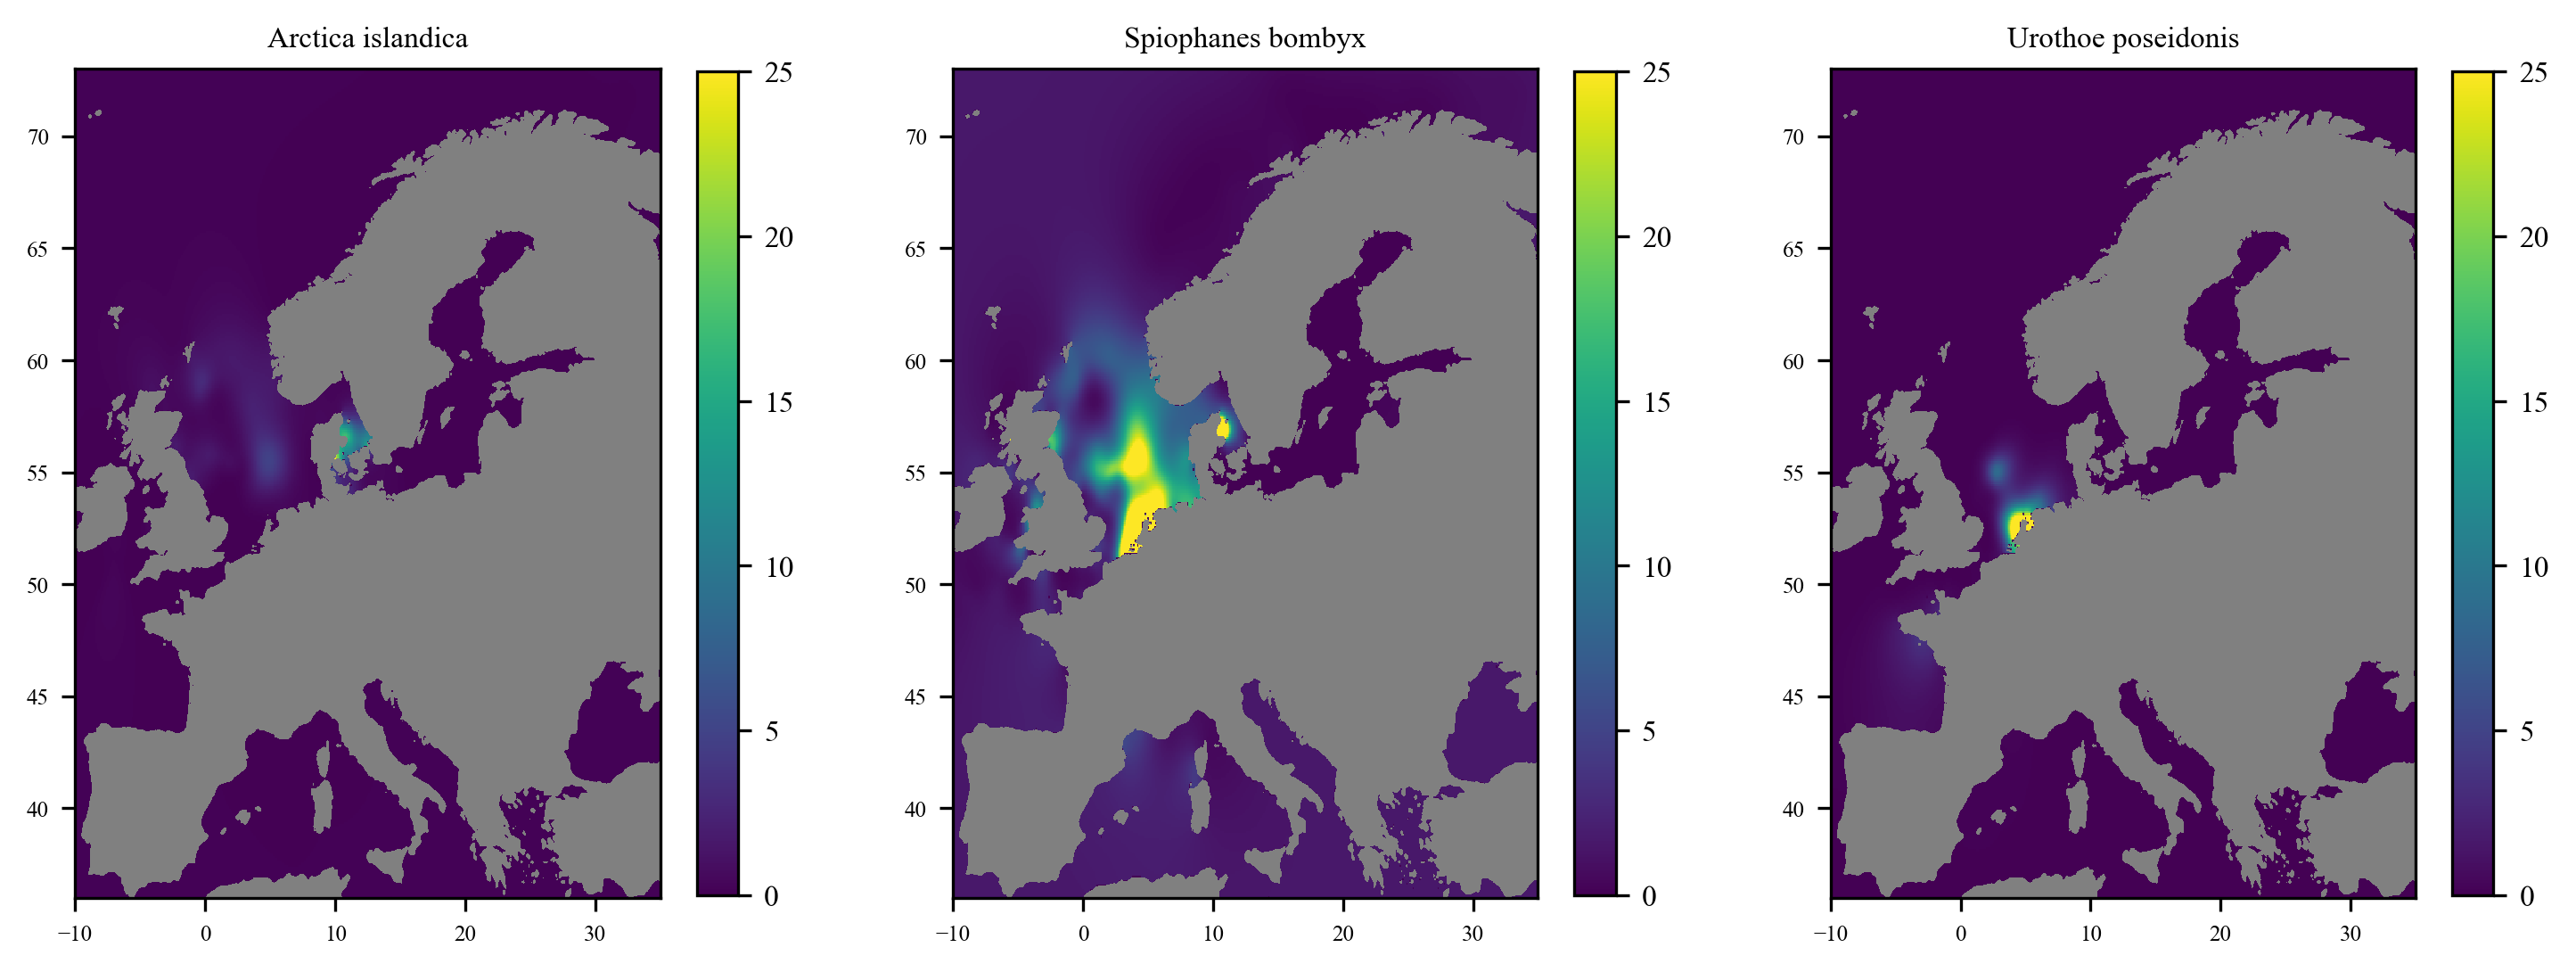

In [44]:
make_plot_grid_spec(fi1abs, fi2abs, fi3abs, vmin=0., vmax=25., shrink=0.5)
PyPlot.savefig(joinpath(figdirBenthos, "Benthos_Specific_cases.png"), 
    dpi=300, bbox_inches="tight")

## Error field
We use the so-called *Clever Poor Man's Estimate*.

In [34]:
g1_err, g2_err, g3_err = compute_error(obslon, obslat, g1, g2, g3);

### Make plot

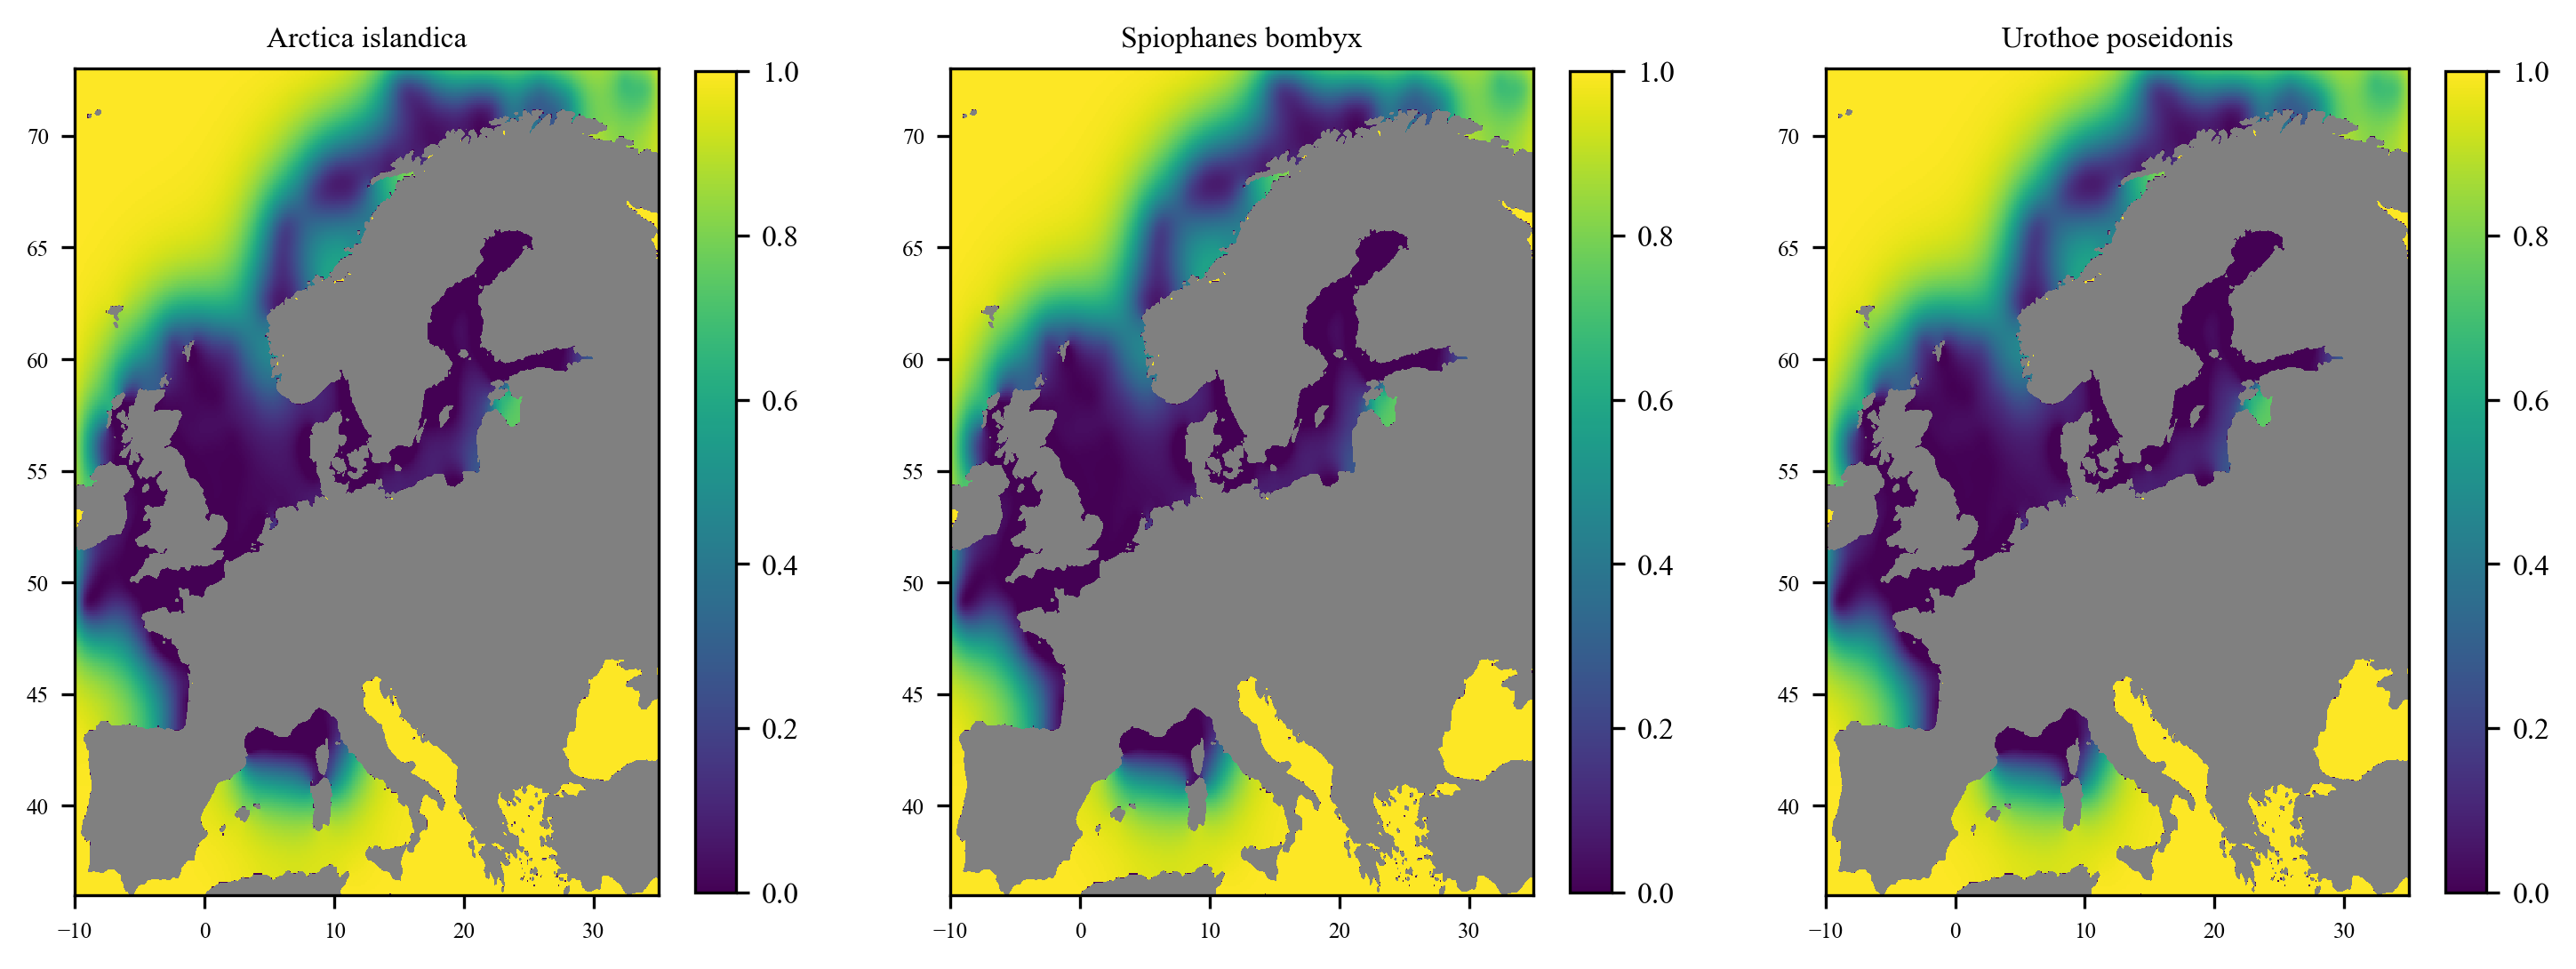

In [45]:
make_plot_grid_spec(g1_err, g2_err, g3_err, vmin=0, vmax=1., shrink=.5)
PyPlot.savefig(joinpath(figdirBenthos, "Benthos_Specific_cases_error.png"), 
        dpi=300, bbox_inches="tight")

## Write the results and the error field in a netCDF file
Create new output directory if necessary.

In [47]:
@info "Write netCDF file $(outputfile)"
write_benthos_nc(outputfile, gridlonBenthos, gridlatBenthos,
    fi1abs, fi2abs, fi3abs, g1_err, g2_err, g3_err);

┌ Info: Write netCDF file ../output/benthos/Benthos_Specific_cases.nc
└ @ Main In[47]:1
